# Week 05 – Federated Learning

We are using `flwr`, a package for federated learning. You can find the documentation and examples here: https://flower.ai

We follow the `flwr` tutorial provided here: https://colab.research.google.com/github/adap/flower/blob/main/examples/simulation-pytorch/sim.ipynb

## set up

```
pip install pandas numpy scikit-learn matplotlib torch torchvision flwr-datasets

pip install -U flwr["simulation"]
```

In [13]:
import warnings
warnings.filterwarnings("ignore")
import flwr as fl

# The data

### Load dataset from `flwr_datasets`

In federated learning, each client has its own data partition. We can use the function `FederatedDataset` from `flwr_datasets` to load the data and create n partitions of it, where n is the number of clients.

In [14]:
from datasets import Dataset
from flwr_datasets import FederatedDataset

# Let's set a simulation involving a total of 100 clients
NUM_CLIENTS = 100

# Download MNIST dataset and partition the "train" partition (so one can be assigned to each client)
mnist_fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
# Let's keep the test set as is, and use it to evaluate the global model on the server
centralized_testset = mnist_fds.load_full("test")

#### Q: What is the `centralized_testset` used for?

Like the name suggests, the centralized test data is a dataset that lies at the server and allows to evaluate the global model on server side. 

#### Q: What does `NUM_CLIENTS = 100` mean?

We have 100 clients that each have their own (training) data. Each client can train the model locally and with their own data. Each client sends their model weights to the server where the models are aggregated to build the global model.

### Define function to transform data

In [15]:
from torchvision.transforms import ToTensor, Normalize, Compose

def apply_transforms(batch):
    """Get transformation for MNIST dataset"""

    # transformation to convert images to tensors and apply normalization
    transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    batch["image"] = [transforms(img) for img in batch["image"]]
    return batch

# The model

### Define the model architecture

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Q: How many layers does this network have? 

7 layers: Convolutional layer (self.conv1), Max pooling layer (self.pool), Convolutional layer (self.conv2), Max pooling layer (self.pool), Fully connected layer (self.fc1), Fully connected layer (self.fc2), Fully connected layer (self.fc3)

### Define functions to train model

These functions will be needed later on by each client when they fit the model locally on their data.

In [17]:
def train(net, trainloader, optim, epochs, device: str):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optim.step()


def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

# The client

In federated learning we have multiple clients that each own some data and train a model locally with this data. 


### Defining the Flower Client 

A Flower Client is a simple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. 

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. 

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

In [18]:
from collections import OrderedDict
from typing import Dict, List, Tuple

from flwr.common import NDArrays, Scalar


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10)
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device

    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # read from config
        lr, epochs = config["lr"], config["epochs"]

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)

        # do local training
        train(self.model, self.trainloader, optim, epochs=epochs, device=self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader, device=self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

### Assigning partition of the data to a client

In [19]:
from torch.utils.data import DataLoader

def get_client_fn(dataset: FederatedDataset):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Let's get the partition corresponding to the i-th client
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)

        trainset = client_dataset_splits["train"]
        valset = client_dataset_splits["test"]

        # Now we apply the transform to each batch.
        trainloader = DataLoader(
            trainset.with_transform(apply_transforms), batch_size=32, shuffle=True
        )
        valloader = DataLoader(valset.with_transform(apply_transforms), batch_size=32)

        # Create and return client
        return FlowerClient(trainloader, valloader).to_client()

    return client_fn


client_fn_callback = get_client_fn(mnist_fds)

## Aggregation strategy – Federated Averaging


The core steps of federated learning are sampling clients, sending the global model to the clients so they can run `fit()` locally on their training data, receive updated models from each client, aggregate these models to construct a new global model, evaluate model.

There are different ways to aggregate all the model updates received from the clients. The probably most well-known is _federated averaging_, see the paper by [McMahan et al. (2016)](https://arxiv.org/abs/1602.05629) for more details.

We need to define the strategy used for aggregation in `flwr`.

### Function to evaluate on centralized test set

In [20]:
def get_evaluate_fn(centralized_testset: Dataset):
    """This is a function that returns a function. The returned function (i.e. `evaluate_fn`) will be 
    executed by the strategy at the end of each round to evaluate the state of the global model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate a model and replace its 
        parameters with those from the global model. Then, the model will be evaluate on the test
        set (recall this is the whole MNIST test set)."""

        model = Net(num_classes=10)

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # Apply transform to dataset
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # call test
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn

### Extra functionality

We are writing two functions – (1) `fit_config()` where we can configure how clients do local training (we can specify nr of epochs, learning rate, etc.), and (2) `weighted_average()` which aggregates the performance metrics (accuracy in this case) that the clients return.

In [22]:
from flwr.common import Metrics

def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 1,  # Number of local epochs done by clients
        "lr": 0.01,  # Learning rate to use by clients during fit()
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Define strategy

Using these functions, we can define the strategy.

In [23]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

# Run simulation

In [24]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources)

INFO flwr 2024-03-06 13:53:48,521 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-03-06 13:53:53,773	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-06 13:53:54,650 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 11243003085.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-03-06 13:53:54,651 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-06 13:53:54,651 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-06 13:53:54,666 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2024-03-06 13:53:54,667 | server.py:89 | Initializing global parameters
INFO flwr 2024-03-06 13:53:54,667 | server.py:276 | Requesting initial parameters from one 

DEBUG flwr 2024-03-06 13:54:45,256 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2024-03-06 13:54:45,257 | server.py:153 | FL finished in 35.361236499998995
INFO flwr 2024-03-06 13:54:45,258 | app.py:226 | app_fit: losses_distributed [(1, 4.58011155128479), (2, 4.527850246429443), (3, 4.365032291412353), (4, 3.6303680419921873), (5, 1.6629256844520568), (6, 1.229364562034607), (7, 0.7963882207870483), (8, 0.9831278324127197), (9, 0.7441721618175506), (10, 0.5860501766204834)]
INFO flwr 2024-03-06 13:54:45,258 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO flwr 2024-03-06 13:54:45,259 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.14666666666666667), (2, 0.25999999999999995), (3, 0.5233333333333334), (4, 0.5799999999999998), (5, 0.7533333333333333), (6, 0.8733333333333334), (7, 0.8766666666666667), (8, 0.8400000000000001), (9, 0.8833333333333332), (10, 0.8933333333333333)]}
INFO flwr 2024-03-06 13:54:45,259 | app.py:229 | app_f

(raylet) [2024-03-06 13:59:04,498 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7354978304; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 13:59:14,509 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7354671104; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 13:59:24,525 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7354339328; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 13:59:34,560 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7354003456; capacity: 494384795648. Object 

(raylet) [2024-03-06 14:04:05,349 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7353368576; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:04:15,358 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7353008128; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:04:25,368 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7352688640; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:04:35,398 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7352315904; capacity: 494384795648. Object 

(raylet) [2024-03-06 14:09:05,833 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7363182592; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:09:15,848 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7362121728; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:09:25,865 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7362191360; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:09:35,909 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7361257472; capacity: 494384795648. Object 

(raylet) [2024-03-06 14:14:06,590 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7355375616; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:14:16,668 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7355318272; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:14:26,752 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7355097088; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:14:36,830 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7355060224; capacity: 494384795648. Object 

(raylet) [2024-03-06 14:19:09,059 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7354966016; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:19:19,141 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7354716160; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:19:29,229 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7354462208; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:19:39,302 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7358492672; capacity: 494384795648. Object 

(raylet) [2024-03-06 14:53:47,121 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7333117952; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:53:57,201 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7332786176; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:54:07,288 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7331770368; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 14:54:17,367 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7335784448; capacity: 494384795648. Object 

(raylet) [2024-03-06 15:46:39,340 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7339610112; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 15:46:49,416 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7338385408; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 16:02:36,348 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7338311680; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-03-06 16:10:31,606 E 47219 36941541] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-06_13-53-50_270863_40787 is over 95% full, available space: 7335137280; capacity: 494384795648. Object 

# Evaluation 

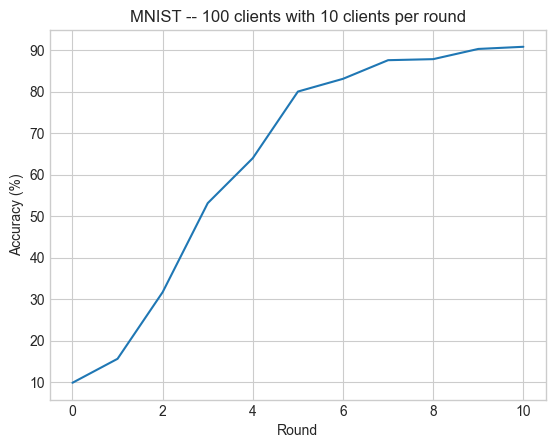

In [25]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# get centralized evaluation accuracy scores per round
global_accuracy_centralised = history.metrics_centralized["accuracy"] 
r = [data[0] for data in global_accuracy_centralised] # rounds
acc = [100.0 * data[1] for data in global_accuracy_centralised] # scores
plt.plot(r, acc)

# axis labels & title
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title(f"MNIST -- {NUM_CLIENTS} clients with 10 clients per round")
plt.show()

#### Q: Explain what can be seen in the plot. 

The plot visualizes the accuracy of the model on the centralized test set (so this is centralized evaluation) by round. We ran the simulation per round, where each round some clients train their model and the global model is updated. As we would expect, the model improves with each round and the improvement is less steep in later rounds as the model will eventually converge on the weights. The accuracy of the final model is around 90%, where it also seems to convert. If we would run it for more rounds we could make a better judgement of where is really converges.